In [2]:
import tensorflow as tf

In [4]:
train=r"/home/teaching/Atmega_MIC/DP Students/Abhay/cropwise_data/tea"
training_set = tf.keras.utils.image_dataset_from_directory(
    train,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=16,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 711 files belonging to 8 classes.


In [5]:
classes = training_set.class_names
classes

['tea_algal_leaf',
 'tea_anthracnose',
 'tea_bird_eye_spot',
 'tea_brown_blight',
 'tea_gray_light',
 'tea_healthy',
 'tea_red_leaf_spot',
 'tea_white_spot']

In [6]:
total_batches = tf.data.experimental.cardinality(training_set).numpy()
train_size = int(0.8 * total_batches)
val_size = total_batches - train_size
train_dataset = training_set.take(train_size)
val_dataset = training_set.skip(train_size)
print(len(training_set))
print(len(train_dataset))
print(len(val_dataset))

45
36
9


In [8]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(8, activation='softmax')  # 6 classes
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])


In [9]:
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation
from tensorflow.keras import Sequential

preprocessing = Sequential([
    Rescaling(1./255),
    RandomFlip("horizontal"),
    RandomRotation(0.1)
])

train_ds = train_dataset.map(lambda x, y: (preprocessing(x), y))
val_ds = val_dataset.map(lambda x, y: (x / 255.0, y))


In [10]:
early_stop = callbacks.EarlyStopping(patience=3, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(factor=0.4, patience=3, min_lr=1e-6)

In [11]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10,
                    callbacks=[early_stop, reduce_lr])

Epoch 1/10
36/36 [==============================] - 8s 182ms/step - loss: 1.2792 - categorical_accuracy: 0.5330 - val_loss: 0.6814 - val_categorical_accuracy: 0.7556 - lr: 0.0010
Epoch 2/10
36/36 [==============================] - 6s 164ms/step - loss: 0.5661 - categorical_accuracy: 0.8090 - val_loss: 0.6103 - val_categorical_accuracy: 0.7407 - lr: 0.0010
Epoch 3/10
36/36 [==============================] - 6s 163ms/step - loss: 0.4165 - categorical_accuracy: 0.8628 - val_loss: 0.3961 - val_categorical_accuracy: 0.8963 - lr: 0.0010
Epoch 4/10
36/36 [==============================] - 6s 163ms/step - loss: 0.3162 - categorical_accuracy: 0.8976 - val_loss: 0.2841 - val_categorical_accuracy: 0.9259 - lr: 0.0010
Epoch 5/10
36/36 [==============================] - 6s 156ms/step - loss: 0.2461 - categorical_accuracy: 0.9253 - val_loss: 0.3925 - val_categorical_accuracy: 0.8889 - lr: 0.0010
Epoch 6/10
36/36 [==============================] - 6s 161ms/step - loss: 0.2519 - categorical_accuracy: 

In [12]:
train_loss,train_acc = model.evaluate(train_ds)

36/36 [==============================] - 4s 91ms/step - loss: 0.0610 - categorical_accuracy: 0.9948


In [13]:
val_loss,val__acc = model.evaluate(val_ds)

9/9 [==============================] - 2s 66ms/step - loss: 0.1288 - categorical_accuracy: 0.9926


In [14]:
model.save("trained_models/trained_model_tea.keras")

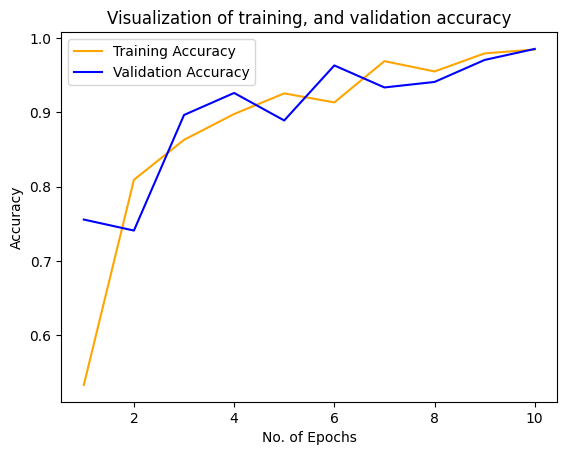

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

epochs=[i for i in range(1,11)]
plt.plot(epochs,history.history['categorical_accuracy'],color='orange',label='Training Accuracy')
plt.plot(epochs,history.history['val_categorical_accuracy'],color='blue',label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Visualization of training, and validation accuracy')
plt.legend()
plt.show()
